In [1]:
cd /home/c01muya/vae-disentanglement/disentanglement_lib_pl

/home/c01muya/vae-disentanglement/disentanglement_lib_pl


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

from vae_experiment import VAEExperiment
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
from notebook_utils import *

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})
np.set_printoptions(suppress=True,precision=4)

In [3]:
npz_path = "../datasets/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
dsprites = load_dsprites(npz_path)

In [4]:
curr_dev = torch.device("cuda:4")
batch_size = 144
seed = 123

In [5]:
beta = 1.0
z_dim = 6
batch_size = 144
checkpoint_path="../pl-dt-test/dsprites_full_beta1/version_0/checkpoints/epoch=51-step=539135.ckpt"

acts_for_dsprites_full, dsprites_full_dataset, model_dsprites_full  = load_model_and_data_and_get_activations(
                    dset_name='dsprites_full', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=curr_dev, 
                    activation_with_label=False, seed=123,  batches=2000
    )

 43%|█████████████████▊                       | 2000/4608 [00:11<00:14, 180.30it/s]


For factor 1 (shape) estimated responsible dim is 1.
For factor 2 (scale) estimated responsible dim is 3.
For factor 3 (orientation) estimated responsible dim is 1.
For factor 4 (posX) estimated responsible dim is 2.
For factor 5 (posY) estimated responsible dim is 4.


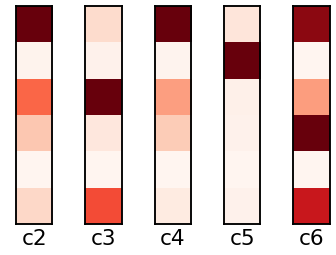

In [6]:
factors = ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
dimwise_variances = np.zeros(shape=(5,6))

for factor_idx in range(1,6):
    
    pairs = sample_latent_pairs_differing_in_one_factor(factor_idx, dsprites, how_many_pairs=10000)
    _, dimwise_variance, est_resp_dim = estimate_responsible_dimension(pairs, model_dsprites_full, curr_dev)
    dimwise_variances[factor_idx - 1, :] = dimwise_variance
    print(f"For factor {factor_idx} ({factors[factor_idx]}) estimated responsible dim is {est_resp_dim + 1}.")

fig, axs = plt.subplots(1,5)
for i, dv in enumerate(dimwise_variances):
    
    axs[i].imshow(np.expand_dims(dv, axis=1), cmap='Reds', interpolation='nearest')
    axs[i].set_yticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_xticklabels([])
    axs[i].set_xlabel('c'+str(i+2))

Note that 5th dimension is dead for this network and 6th dimension was not attributed to any 1 factor but still shows significant variance for `factor 2 (scale)` and `factor 5 (posY)`

1. **[Shape]** Semantic tr doesn't make sense for categorical vars e.g. `shape`. The notion of maximally different doesn't apply here. However, we see that changing `shape` also changes `rotation` in most cases. This could be because estimated resp. dim for both `shape` and `rotation` is dim 1
2. **[Scale]**  We are largely successful in changing `scale`, but it can lead to a change of `shape` as well. This could be because changes in `shape` also perturb dim 3 (to a lesser extent). 
3. **[Orientation]**  Change of `orientation` not successful. `orientation` change can also affect `shape`. This makes sense as change of `shape` is associated with dim 1 and dim 3 which are both affected strongly by `orientation`
4. **[PosX]** We are largely successful in changing `PosX` but it can also affect `shape`. This is strange because there is only very slight variantion in dim 1 because of change in `posX`, certainly not proportional to the number of examples we see affected.
5. **[PosY]** Change of `PosY`leads to strange results. It always changes `shape` or some other attribute as well or fails. We can see that variation in `posY` leads to variation in dims 1,3,4,6 so this behaviour is basically what we'd expect. Interesting is to ask why this happens with `posY`... It can't be more complicated to disentangle than `posX` which is very clearnly separated.

In [1]:
# normalized_responsibilities = dimwise_variances.T / np.linalg.norm(dimwise_variances, ord=1, axis=1)
# fig, axs = plt.subplots(1,5)
# for i, dv in enumerate(normalized_responsibilities.T):
    
#     axs[i].imshow(np.expand_dims(dv, axis=1), cmap='Reds', interpolation='nearest')
#     axs[i].set_yticklabels([])
#     axs[i].set_yticks([])
#     axs[i].set_xticks([])
#     axs[i].set_xticklabels([])
#     axs[i].set_xlabel('c'+str(i+2))

### Transferring shape

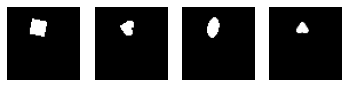

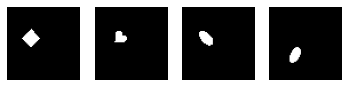

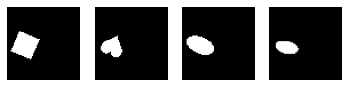

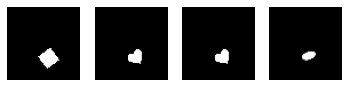

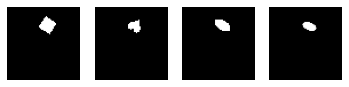

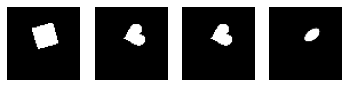

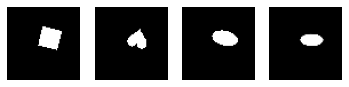

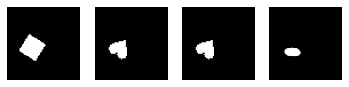

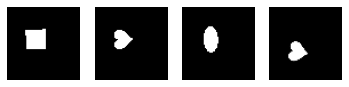

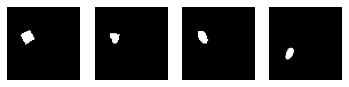

In [7]:
max_diff_pairs = sample_latent_pairs_maximally_differing_in_one_factor(
    diff_factor_idx=1, 
    npz_dataset=dsprites, 
    direction='min-to-max', 
    how_many_pairs=10,
    latent_max_val=dsprites['latents_sizes'][1]-1)

# we do a semantic tr for every pair
for pairs in max_diff_pairs:
    
    mus, logvars, new_img = do_semantic_manipulation(pairs['images'], model_dsprites_full, curr_dev)

### Transferring scale

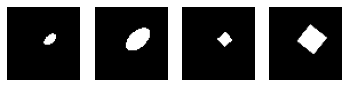

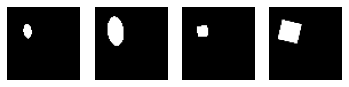

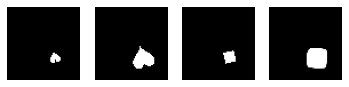

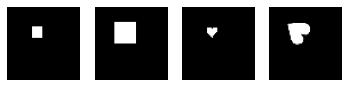

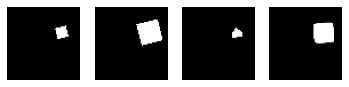

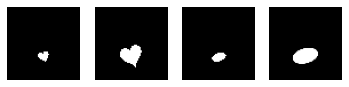

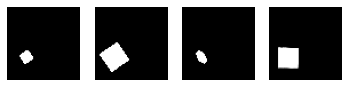

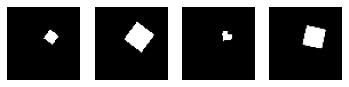

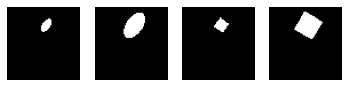

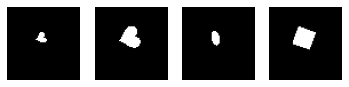

In [8]:
max_diff_pairs = sample_latent_pairs_maximally_differing_in_one_factor(
    diff_factor_idx=2, 
    npz_dataset=dsprites, 
    direction='min-to-max', 
    how_many_pairs=10,
    latent_max_val=dsprites['latents_sizes'][2]-1)

# we do a semantic tr for every pair
for pairs in max_diff_pairs:
    
    mus, logvars, new_img = do_semantic_manipulation(pairs['images'], model_dsprites_full, curr_dev)

### Transferring orientation

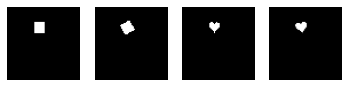

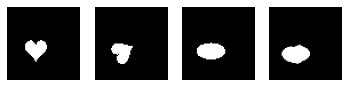

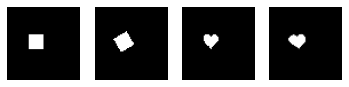

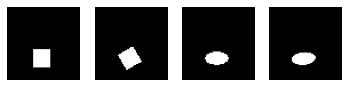

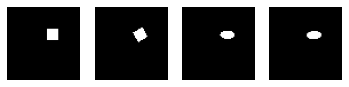

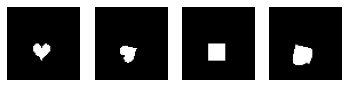

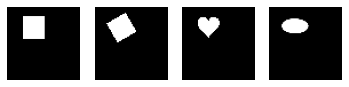

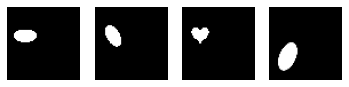

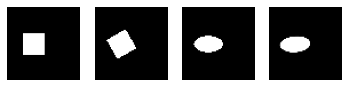

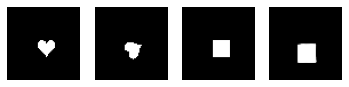

In [9]:
max_diff_pairs = sample_latent_pairs_maximally_differing_in_one_factor(
    diff_factor_idx=3, 
    npz_dataset=dsprites, 
    direction='min-to-max', 
    how_many_pairs=10,
    latent_max_val=dsprites['latents_sizes'][3]//3)

# we do a semantic tr for every pair
for pairs in max_diff_pairs:
    
    mus, logvars, new_img = do_semantic_manipulation(pairs['images'], model_dsprites_full, curr_dev)

### Transferring posX

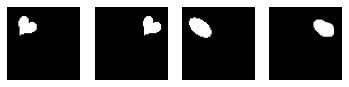

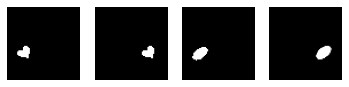

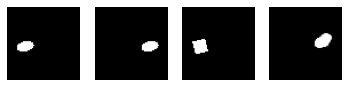

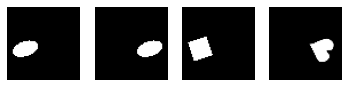

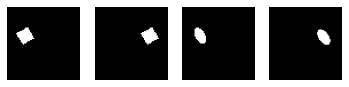

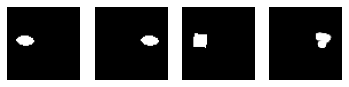

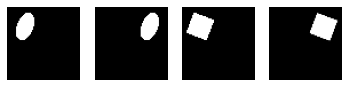

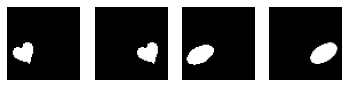

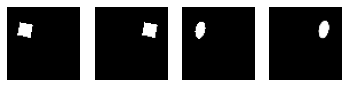

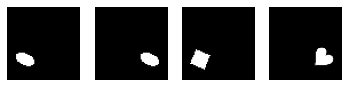

In [10]:
max_diff_pairs = sample_latent_pairs_maximally_differing_in_one_factor(
    diff_factor_idx=4, 
    npz_dataset=dsprites, 
    direction='min-to-max', 
    how_many_pairs=10,
    latent_max_val=dsprites['latents_sizes'][4]-1)

# we do a semantic tr for every pair
for pairs in max_diff_pairs:
    
    mus, logvars, new_img = do_semantic_manipulation(pairs['images'], model_dsprites_full, curr_dev)
    

### Transferring posY

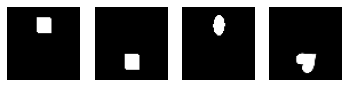

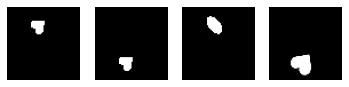

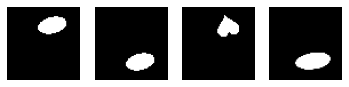

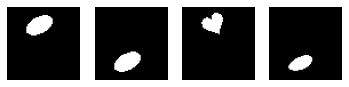

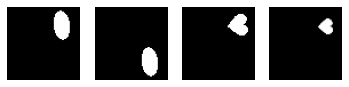

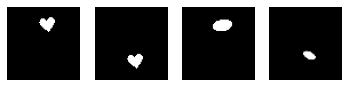

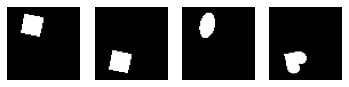

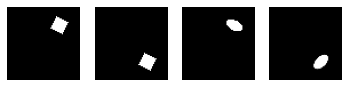

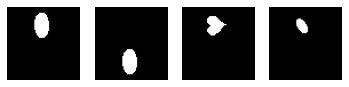

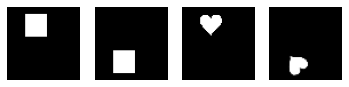

In [12]:
max_diff_pairs = sample_latent_pairs_maximally_differing_in_one_factor(
    diff_factor_idx=5, 
    npz_dataset=dsprites, 
    direction='min-to-max', 
    how_many_pairs=10,
    latent_max_val=dsprites['latents_sizes'][5]-1
)

# we do a semantic tr for every pair
for pairs in max_diff_pairs:
    
    mus, logvars, new_img = do_semantic_manipulation(pairs['images'], model_dsprites_full, curr_dev)


In [3]:
t = torch.Tensor([1,2,3])

In [4]:
t

tensor([1., 2., 3.])

In [5]:
t[2] = 5

In [6]:
t

tensor([1., 2., 5.])

<AxesSubplot:>

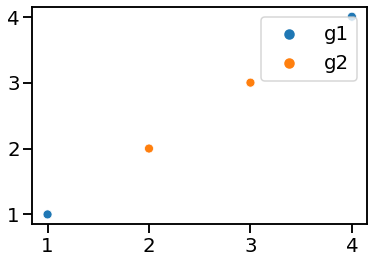

In [9]:
sns.scatterplot(x=[1,2,3,4],y=[1,2,3,4],hue=['g1','g2','g2','g1'])